In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics

In [ ]:
df = pd.read_csv("battingstats.csv",low_memory=False,parse_dates=True)
df

In [ ]:
# First deal with Player and Span columns to extract nationality & Start and End dates
nationality = pd.Series([], dtype="int16")
player = pd.Series([], dtype="int16")
startdate = pd.Series([], dtype="int16")
enddate = pd.Series([], dtype="int16")

for index, name in enumerate(df.Player):
    # Find all occurrences of brackets. 
    startBrac = str(name).find("(")
    endBrac = str(name).find(")")
    nationality[index] = str(name)[startBrac+1:endBrac]
    player[index] = str(name)[:startBrac]
    while True:
        startBrac = str(name).find("(", endBrac)
        endBrac = str(name).find(")", startBrac)
        if startBrac != -1:
            if len(str(name)[startBrac+1:endBrac])>1:
                nationality[index] = str(name)[startBrac+1:endBrac]
        if startBrac == -1:
            break

for idx, date in enumerate(df.Span):
    dashloc = str(date).find("-")
    startdate[idx] = int(str(date)[:dashloc])
    enddate[idx] = int(str(date)[dashloc+1:])

df.drop(columns=["Player","Span"], inplace=True)
df["Nationality"] = nationality
df["Player"] = player
df["StartDate"] = startdate
df["EndDate"] = enddate

In [ ]:
df.StartDate = df.StartDate.astype("int16")
df.EndDate = df.EndDate.astype("int16")

In [ ]:
df

In [ ]:
# Analyse PlayerRole
df["Player Role"].unique()

In [ ]:
# Should I combine wicketkeeper & wicketkeeper batsman?
df2 = df.copy()
df2 = df2[df2.Ave != "-"]
df2.Ave = df2.Ave.astype("float16")

In [ ]:
rolesummary = df2[["Ave", "Player Role"]].groupby("Player Role").mean()
rolesummary["St. Deviation"] = df2[["Ave", "Player Role"]].groupby("Player Role").std().Ave.values
rolesummary

In [ ]:
# In the context of cricket, averages of 21 and 28 are poor, but are also significantly different from each other. 
# Given that the batting average for a wicketkeeper seems to vary quite a bit less than that of a wicketkeeper batsman, I choose to keep these classes separate
# There does appear to be a case to merge opening & top-order batsmen together -> don't merge
# As well as "allrounder" and "bowling allrounder" -> merge these
# Decisions made based on prior cricketing knowledge. Will make a model where I merge both, however.
playerRole = pd.Series([], dtype="object")
for index, role in enumerate(df["Player Role"]):
    if str(role) == "allrounder":
        playerRole[index] = "bowling allrounder"
    else:
        playerRole[index] = str(role)
        
df["Player Role"] = playerRole

In [ ]:
df.Nationality.unique()

In [ ]:
# ICC teams aren't too important, so in theory I should merge ICC/SA with SA etc etc but let's see if there is any statistical base to this
df2 = df.copy()
df2 = df2[df2.Ave != "-"]
df2.Ave = df2.Ave.astype("float16")
rolesummary = df2[["Ave", "Nationality"]].groupby("Nationality").mean()
rolesummary["St. Deviation"] = df2[["Ave", "Nationality"]].groupby("Nationality").std().Ave.values
rolesummary["Count"] = df2[["Ave", "Nationality"]].groupby("Nationality").count().Ave.values
rolesummary

In [ ]:
# First look at the NaNs. They are caused because we have only a single piece of data in each of those categories.
# Hence merge ICC/WI and WI, ICC/SL and SL, ICC/Pak and Pak, ICC/NZ and NZ and ENG/IRE with IRE
# Due to the variability in ENG/ICC and ICC/SA, merge these players into ENG and SA teas respectively
iccdict = {"ICC/WI":"WI","ICC/SL":"SL","ICC/PAK":"PAK","ICC/NZ":"NZ","ENG/IRE":"IRE","ENG/ICC":"ENG","ICC/SA":"SA"}
for key, value in iccdict.items():
    for index, nation in enumerate(df.Nationality):
        if nation == key:
            df.Nationality[index] = value

In [ ]:
df.Nationality.unique()

In [ ]:
df["Batting Style"].unique() # Good

In [ ]:
# Now need to analyse the columns with an Average of "-"
df3 = df[df.Ave=="-"]
df3

In [ ]:
features = ["Hundreds","Fifties","Ducks","Runs","NO","Inns","HS"]
for name in features:
    for index, item in enumerate(df[name]):
        if str(item)=="-":
            df[name][index] = "0"

df["Hundreds"] = df["Hundreds"].astype("int8")
df["Fifties"] = df["Fifties"].astype("int8")
df["Ducks"] = df["Ducks"].astype("int8")
df["Runs"] = df["Runs"].astype("int16")
df["NO"] = df["NO"].astype("int8")
df["Inns"] = df["Inns"].astype("int16")
df["HS"] = df["HS"].astype("int16")
df["Mat"] = df["Mat"].astype("int16")

In [ ]:
df3 = df[df["Ave"]=="-"]
df3

In [ ]:
# Notice that Ave="-" if Inns=NO
# if Inns=NO=0, set Ave = 0
# if Inns=NO>0, set Ave = Runs/Inns
for index, item in enumerate(df.Ave):
    if str(item) == "-":
        if df.Inns[index] == 0 and df.NO[index] == 0:
            df.Ave[index] = "0"
        elif df.Inns[index] == df.NO[index] and float(df.Inns[index])>0:
            df.Ave[index] = float(df.Runs[index])/float(df.Inns[index])
df.Ave = df.Ave.astype("float16")

In [ ]:
df.dtypes

In [ ]:
for col in df.columns:
    if pd.api.types.is_string_dtype(df[col]):
        df[col] = pd.Categorical(df[col])

In [ ]:
df.dtypes

In [ ]:
df["HS-N/O?"] = pd.Categorical(df["HS-N/O?"],categories=["No","Yes"],ordered=True)

In [ ]:
# Can we order the player roles?
averole = df[["Player Role","Ave"]].groupby("Player Role").mean()
averole["Std. Dev"] = df[["Player Role","Ave"]].groupby("Player Role").std()
averole = averole.sort_values(by="Ave",ascending=False)
averole

In [ ]:
# Consider the order: top order > middle order > batsman > opener
# > batAllRounder > wicketBatsman > bowling allrounder > wicketkeeper
# > nan > bowler
rolcat = ["bowler","nan","wicketkeeper","bowling allrounder","wicketkeeper batsman","batting allrounder","opening batsman","batsman","middle-order batsman","top-order batsman"]
df["Player Role"] = pd.Categorical(df["Player Role"],categories=rolcat,ordered=True)
df["Player Role"]

In [ ]:
# Preprocessing done
df = df.sort_values(by="StartDate",ascending=True)
df.index = np.arange(0,len(df))
df.to_feather("processedData") # Store processed data

In [2]:
# Split into training, validation and test
df = pd.read_feather("processedData")
df

,Mat,Inns,NO,Runs,HS,HS-N/O?,Ave,Hundreds,Fifties,Ducks,Batting Style,Player Role,Nationality,Player,StartDate,EndDate
0,9,13,2,502,101,Yes,45.625000,1,3,0,R,nan,NZ,JV Coney,1986,1987
1,2,3,0,20,16,No,6.660156,0,0,0,L,nan,SL,SAR Silva,1986,1988
2,44,68,5,934,88,No,14.820312,0,4,10,R,bowler,ENG,PAJ DeFreitas,1986,1995
3,3,4,1,21,12,Yes,7.000000,0,0,1,R,nan,ENG,NV Radford,1986,1988
4,38,72,5,3019,185,No,45.062500,8,14,4,L,opening batsman,NZ,JG Wright,1986,1993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1422,2,3,0,24,16,No,8.000000,0,0,1,R,top-order batsman,BDESH,Saif Hassan,2020,2020
1423,2,2,0,93,49,No,46.500000,0,0,0,R,bowler,NZ,KA Jamieson,2020,2020
1424,3,4,0,113,63,No,28.250000,0,1,0,R,nan,ZIM,KT Kasuza,2020,2020
1425,1,2,1,9,5,Yes,9.000000,0,0,0,L,bowler,SA,BE Hendricks,2020,2020


In [3]:
def trainTestSplit(dataset):
    X_train = dataset[dataset.StartDate <= 2007]
    y_train = X_train.Ave
    X_train.drop(columns=["Ave"],inplace=True)
    
    X_valid = dataset[dataset.StartDate > 2007]
    X_valid = X_valid[X_valid.StartDate <=2010]
    y_valid = X_valid.Ave
    X_valid.drop(columns=["Ave"],inplace=True)
    
    X_test = dataset[dataset.StartDate > 2010]
    y_test = X_test.Ave
    X_test.drop(columns=["Ave"],inplace=True)
    
    return X_train,y_train,X_valid,y_valid,X_test,y_test

X_train, y_train, X_valid, y_valid, X_test, y_test = trainTestSplit(df)

C:\Users\rushi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pandas\core\frame.py:4157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\rushi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pandas\core\frame.py:4157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [4]:
sets = [X_train,X_valid,X_test]

for dataset in sets:
    for field,data in dataset.items():
        if pd.api.types.is_categorical_dtype(data):
            dataset[field] = data.cat.codes
        
X_train

<ipython-input-4-aeaa5cd1311a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset[field] = data.cat.codes


,Mat,Inns,NO,Runs,HS,HS-N/O?,Hundreds,Fifties,Ducks,Batting Style,Player Role,Nationality,Player,StartDate,EndDate
0,9,13,2,502,101,1,1,3,0,1,1,7,621,1986,1987
1,2,3,0,20,16,0,0,0,0,0,1,10,1147,1986,1988
2,44,68,5,934,88,0,0,4,10,1,0,3,968,1986,1995
3,3,4,1,21,12,1,0,0,1,1,1,3,927,1986,1988
4,38,72,5,3019,185,0,8,14,4,0,6,7,582,1986,1993
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
908,37,48,5,460,46,0,0,0,9,1,0,9,991,2007,2011
909,14,24,1,821,120,0,2,7,5,0,6,10,1194,2007,2009
910,3,3,1,94,50,1,0,1,1,1,1,8,1404,2007,2009
911,7,13,1,243,83,0,0,1,1,0,7,2,845,2007,2009


0
10
20
30
40
50
60
70
80
90


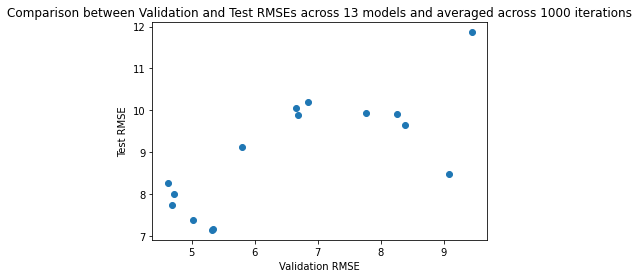

In [6]:
# Calibrate validation set
from sklearn.metrics import mean_squared_error, r2_score

def calibrate():
    # Create first model - Standard Random Forest
    model1 = RandomForestRegressor(n_jobs=-1)
    model1.fit(X_train,y_train)
    model1ValidRMSE = np.sqrt(mean_squared_error(y_valid,model1.predict(X_valid)))
    model1TestRMSE = np.sqrt(mean_squared_error(y_test,model1.predict(X_test)))
    # Create second model - Single Decision Tree
    model2 = RandomForestRegressor(n_jobs=-1,bootstrap=False, n_estimators=1)
    model2.fit(X_train,y_train)
    model2ValidRMSE = np.sqrt(mean_squared_error(y_valid,model2.predict(X_valid)))
    model2TestRMSE = np.sqrt(mean_squared_error(y_test,model2.predict(X_test)))
    # Create third model - Single Decision Stump
    model3 = RandomForestRegressor(n_jobs=-1,bootstrap=False,n_estimators=1,max_depth=1)
    model3.fit(X_train,y_train)
    model3ValidRMSE = np.sqrt(mean_squared_error(y_valid,model3.predict(X_valid)))
    model3TestRMSE = np.sqrt(mean_squared_error(y_test,model3.predict(X_test)))
    # Create fourth model - Random Forest with restricted features & trees
    model4 = RandomForestRegressor(n_jobs=-1, min_samples_leaf = 3, max_features = 0.5)
    model4.fit(X_train,y_train)
    model4ValidRMSE = np.sqrt(mean_squared_error(y_valid,model4.predict(X_valid)))
    model4TestRMSE = np.sqrt(mean_squared_error(y_test,model4.predict(X_test)))
    # Create fifth model - Random Forest with subsampling
    model5 = RandomForestRegressor(n_jobs=-1,max_samples=0.75)
    model5.fit(X_train,y_train)
    model5ValidRMSE = np.sqrt(mean_squared_error(y_valid,model5.predict(X_valid)))
    model5TestRMSE = np.sqrt(mean_squared_error(y_test,model5.predict(X_test)))
    # Create sixth model - Random Forest with subsampling
    model6 = RandomForestRegressor(n_jobs=-1,max_samples=0.5)
    model6.fit(X_train,y_train)
    model6ValidRMSE = np.sqrt(mean_squared_error(y_valid,model6.predict(X_valid)))
    model6TestRMSE = np.sqrt(mean_squared_error(y_test,model6.predict(X_test)))
    # Create seventh model - Random Forest with subsampling and reduced depth
    model7 = RandomForestRegressor(n_jobs=-1,max_samples=0.75,min_samples_leaf=3)
    model7.fit(X_train,y_train)
    model7ValidRMSE = np.sqrt(mean_squared_error(y_valid,model7.predict(X_valid)))
    model7TestRMSE = np.sqrt(mean_squared_error(y_test,model7.predict(X_test)))
    # Create eighth model - Random Forest with subsampling, reduced depth, random feature selection, 2 trees
    model8 = RandomForestRegressor(n_jobs=-1,max_samples=0.75, min_samples_leaf=3, max_features = 0.5, n_estimators=2)
    model8.fit(X_train,y_train)
    model8ValidRMSE = np.sqrt(mean_squared_error(y_valid,model8.predict(X_valid)))
    model8TestRMSE = np.sqrt(mean_squared_error(y_test,model8.predict(X_test)))
    # Create ninth model - Random Forest with subsampling, reduced depth, random feature selection, 1 tree
    model9 = RandomForestRegressor(n_jobs=-1,max_samples=0.75, min_samples_leaf=3, max_features = 0.5, n_estimators=1)
    model9.fit(X_train,y_train)
    model9ValidRMSE = np.sqrt(mean_squared_error(y_valid,model9.predict(X_valid)))
    model9TestRMSE = np.sqrt(mean_squared_error(y_test,model9.predict(X_test)))
    # Create tenth model - Random Forest with subsampling, reduced depth, random feature selection, 1 tree
    model10 = RandomForestRegressor(n_jobs=-1,max_samples=0.5, min_samples_leaf=3, max_features = 0.5, n_estimators=1)
    model10.fit(X_train,y_train)
    model10ValidRMSE = np.sqrt(mean_squared_error(y_valid,model10.predict(X_valid)))
    model10TestRMSE = np.sqrt(mean_squared_error(y_test,model10.predict(X_test)))
    # Create eleventh model - Random Forest with subsampling, reduced depth, random feature selection, 1 tree
    model11 = RandomForestRegressor(n_jobs=-1,max_samples=0.5, min_samples_leaf=5, max_features = 0.5, n_estimators=1)
    model11.fit(X_train,y_train)
    model11ValidRMSE = np.sqrt(mean_squared_error(y_valid,model11.predict(X_valid)))
    model11TestRMSE = np.sqrt(mean_squared_error(y_test,model11.predict(X_test)))
    # Create twelfth model - Random Forest with single tree
    model12 = RandomForestRegressor(n_jobs=-1,bootstrap=True, n_estimators=1)
    model12.fit(X_train,y_train)
    model12ValidRMSE = np.sqrt(mean_squared_error(y_valid,model12.predict(X_valid)))
    model12TestRMSE = np.sqrt(mean_squared_error(y_test,model12.predict(X_test)))
    # Create thirteenth model - Random Forest with single tree and subsampling
    model13 = RandomForestRegressor(n_jobs=-1,bootstrap=True, n_estimators=1, max_samples=0.75)
    model13.fit(X_train,y_train)
    model13ValidRMSE = np.sqrt(mean_squared_error(y_valid,model13.predict(X_valid)))
    model13TestRMSE = np.sqrt(mean_squared_error(y_test,model13.predict(X_test)))
    # Create fourteenth model - Random Forest with single tree, subsampling, reduced depth
    model14 = RandomForestRegressor(n_jobs=-1,bootstrap=True, n_estimators=1, max_samples=0.75, max_depth=4)
    model14.fit(X_train,y_train)
    model14ValidRMSE = np.sqrt(mean_squared_error(y_valid,model14.predict(X_valid)))
    model14TestRMSE = np.sqrt(mean_squared_error(y_test,model14.predict(X_test)))
    # Create fifteenth model - Random Forest with 50 trees
    model15 = RandomForestRegressor(n_jobs=-1,n_estimators=50)
    model15.fit(X_train,y_train)
    model15ValidRMSE = np.sqrt(mean_squared_error(y_valid,model15.predict(X_valid)))
    model15TestRMSE = np.sqrt(mean_squared_error(y_test,model15.predict(X_test)))
    
    x = [model1ValidRMSE,model2ValidRMSE,model3ValidRMSE,model4ValidRMSE,model5ValidRMSE, model6ValidRMSE, model7ValidRMSE,
    model8ValidRMSE, model9ValidRMSE, model10ValidRMSE, model11ValidRMSE, model12ValidRMSE, model13ValidRMSE,
    model14ValidRMSE, model15ValidRMSE]
    y = [model1TestRMSE,model2TestRMSE,model3TestRMSE,model4TestRMSE,model5TestRMSE, model6TestRMSE, model7TestRMSE,
    model8TestRMSE, model9TestRMSE, model10TestRMSE, model11TestRMSE, model12TestRMSE, model13TestRMSE,
    model14TestRMSE, model15TestRMSE]
    return x,y

N = 100
x,y = calibrate()
x = np.asarray(x)
y = np.asarray(y)
for i in range(N):
    newx, newy = calibrate()
    newx = np.asarray(newx)
    newy = np.asarray(newy)
    x = x + newx
    y = y + newy
x = x/float((N+1))
y = y/float((N+1))
plt.figure()

plt.scatter(x,y)
plt.xlabel("Validation RMSE")
plt.ylabel("Test RMSE")
plt.title("Comparison between Validation and Test RMSEs across 13 models and averaged across 1000 iterations")
plt.show()

In [5]:
from scipy.stats import spearmanr
spearmanr(x,y)

NameError: name 'x' is not defined

In [11]:
# It appears as though our validation set is good. The better the Validation RMSE, the better the Test RMSE and vice versa.
score = 0.0
N = 1000
for i in range(N):
    model = RandomForestRegressor(n_jobs=-1, oob_score=True)
    model.fit(X_train,y_train)
    score += model.oob_score_
    
#print("Training R^2:", model.score(X_train,y_train))
#print("Training RMSE:", np.sqrt(mean_squared_error(y_train,model.predict(X_train))))
#print("OOB Score:", model.oob_score_)
print(score/N)

0.8935182889257369


C:\Users\rushi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\ensemble\_forest.py:832: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
C:\Users\rushi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\sklearn\ensemble\_forest.py:832: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


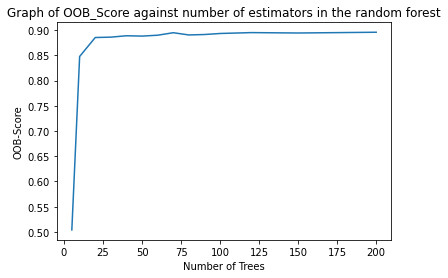

In [12]:
trees = [5,10,20,30,40,50,60,70,80,90,100,120,150,200]
scores = []
for treenum in trees:
    model = RandomForestRegressor(n_jobs=-1,oob_score=True,n_estimators=treenum)
    model.fit(X_train,y_train)
    scores.append(model.oob_score_)
    
plt.title("Graph of OOB_Score against number of estimators in the random forest")
plt.ylabel("OOB-Score")
plt.xlabel("Number of Trees")
plt.plot(trees,scores)
plt.show()

In [13]:
# Choose 100 trees. The more trees, the better but the curve levels off, so there isn't much point going beyond hthis
# Choose between max_features None, sqrt, log2, 0.5 etc
featureSelect = [None,"sqrt","log2",0.5,0.75]
scores = np.asarray([0.0,0.0,0.0,0.0,0.0])
for i in range(500):
    for index, feature in enumerate(featureSelect):
        modeltest = RandomForestRegressor(n_jobs=-1,n_estimators=100,max_features=feature,oob_score=True)
        modeltest.fit(X_train,y_train)
        scores[index] += float(modeltest.oob_score_)
    if i % 50 == 0:
        print(i)
scores = scores/500

0
50
100
150
200
250
300
350
400
450


In [14]:
scores

array([0.89370761, 0.87911828, 0.87943592, 0.89401983, 0.8951569 ])

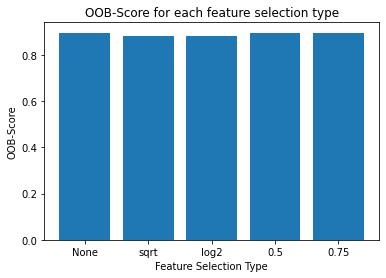

In [15]:
plt.title("OOB-Score for each feature selection type")
plt.ylabel("OOB-Score")
plt.xlabel("Feature Selection Type")
plt.bar(["None","sqrt","log2","0.5","0.75"],scores)
plt.show()

0
50
100
150
200
250
300
350
400
450


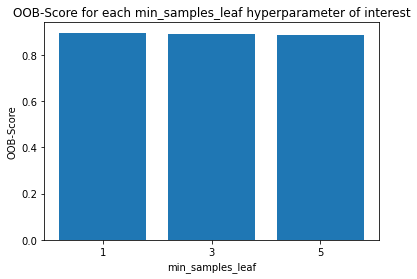

In [16]:
# Choose 0.75 as the value for max_features
# Now consider min_samples_leaf=1,3,5
samplesParam = [1,3,5]
scores = np.asarray([0.0,0.0,0.0])
for i in range(500):
    for index, samples in enumerate(samplesParam):
        modeltest = RandomForestRegressor(n_jobs=-1,n_estimators=100,max_features=0.75,min_samples_leaf=samples,oob_score=True)
        modeltest.fit(X_train,y_train)
        scores[index] += float(modeltest.oob_score_)
    if i % 50 == 0:
        print(i)
scores = scores/500

plt.title("OOB-Score for each min_samples_leaf hyperparameter of interest")
plt.ylabel("OOB-Score")
plt.xlabel("min_samples_leaf")
plt.bar(["1","3","5"],scores)
plt.show()

0
50
100
150
200
250
300
350
400
450


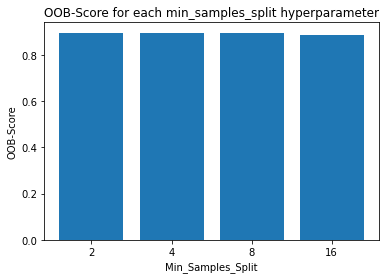

In [17]:
# Keep min_samples_leaf = 1
# Consider min_samples_split = 2,4,8,16
samplesParam = [2,4,8,16]
scores = np.asarray([0.0,0.0,0.0,0.0])
for i in range(500):
    for index, samples in enumerate(samplesParam):
        modeltest = RandomForestRegressor(n_jobs=-1,n_estimators=100,max_features=0.75,min_samples_split=samples,oob_score=True)
        modeltest.fit(X_train,y_train)
        scores[index] += float(modeltest.oob_score_)
    if i % 50 == 0:
        print(i)
scores = scores/500
plt.title("OOB-Score for each min_samples_split hyperparameter")
plt.ylabel("OOB-Score")
plt.xlabel("Min_Samples_Split")
plt.bar(["2","4","8","16"],scores)
plt.show()

In [18]:
scores

array([0.89534464, 0.89493184, 0.89343489, 0.88629624])

0
50
100
150
200
250
300
350
400
450


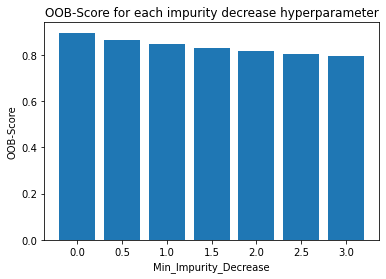

In [19]:
# take min_samples_split to be either 2 or 4. Take 4.
# Tune min_impurity_decrease - 0.0,0.5,1.0,1.5,2.0,2.5,3.0
impureParam = [0.0,0.5,1.0,1.5,2.0,2.5,3.0]
scores = np.asarray([0.0,0.0,0.0,0.0,0.0,0.0,0.0])
for i in range(500):
    for index, impureDecrease in enumerate(impureParam):
        modeltest = RandomForestRegressor(n_jobs=-1,n_estimators=100,max_features=0.75,min_samples_split=4,min_impurity_decrease=impureDecrease,oob_score=True)
        modeltest.fit(X_train,y_train)
        scores[index] += float(modeltest.oob_score_)
    if i % 50 == 0:
        print(i)
scores = scores/500
plt.title("OOB-Score for each impurity decrease hyperparameter")
plt.ylabel("OOB-Score")
plt.xlabel("Min_Impurity_Decrease")
plt.bar(["0.0","0.5","1.0","1.5","2.0","2.5","3.0"],scores)
plt.show()


In [13]:
# Min_impurity_decrease seems best unchanged (as expected)
# Here is the new model:
model = RandomForestRegressor(n_jobs=-1,n_estimators=100,max_features=0.75,min_samples_split=4,oob_score=True)
model.fit(X_train,y_train)
print("Training R^2:", model.score(X_train,y_train))
print("Training RMSE:", np.sqrt(mean_squared_error(y_train,model.predict(X_train))))
print("OOB Score:", model.oob_score_)

Training R^2: 0.9826734331901698
Training RMSE: 1.8021632000806354
OOB Score: 0.9000459840991993


In [21]:
# See how it performs on the validation set
print("Validation R^2:", model.score(X_valid,y_valid))
print("Validation RMSE:", np.sqrt(mean_squared_error(y_valid,model.predict(X_valid))))

Validation R^2: 0.8711273247552038
Validation RMSE: 4.870712960538038


In [53]:
# Have a look at the validation set, move real Averages to the last index
valid = df[df["StartDate"] > 2007]
valid = valid[valid["StartDate"]<=2010]
validcols = list(valid.columns.values)
validcols.pop(validcols.index("Ave"))
valid = valid[validcols+["Ave"]]
# Add model predictions and standard deviations
# validpred is a matrix with the ith row corresponding to the predictions from the ith tree
validpred = np.stack([t.predict(X_valid) for t in model.estimators_])
valid["Predictions"] = validpred.mean(axis=0)
valid["Std. Dev"] = validpred.std(axis=0)
valid.sort_values(by="Std. Dev", ascending=False).head(20)

,Mat,Inns,NO,Runs,HS,HS-N/O?,Hundreds,Fifties,Ducks,Batting Style,Player Role,Nationality,Player,StartDate,EndDate,Ave,Predictions,Std. Dev
1008,1,2,0,88,88,No,0,1,1,R,wicketkeeper batsman,PAK,Zulqarnain Haider,2010,2010,44.000000,72.446209,30.382991
986,2,4,0,160,94,No,0,1,0,L,opening batsman,WI,OJ Phillips,2009,2009,40.000000,44.943200,24.339258
953,1,1,0,58,58,No,0,1,0,L,bowling allrounder,SA,JA Morkel,2009,2009,58.000000,41.856185,19.961637
1030,2,3,0,63,56,No,0,1,0,R,middle-order batsman,INDIA,S Badrinath,2010,2010,21.000000,30.094301,11.267875
1004,2,3,1,47,33,Yes,0,0,0,L,bowling allrounder,SA,R McLaren,2010,2014,23.500000,23.026240,9.839415
983,3,6,0,250,168,No,1,0,0,L,top-order batsman,PAK,Fawad Alam,2009,2009,41.656250,40.656156,9.818394
957,4,6,1,107,68,No,0,1,1,R,bowling allrounder,AUS,AB McDonald,2009,2009,21.406250,28.446651,9.664323
962,3,6,0,125,69,No,0,1,1,R,batsman,WI,DM Richards,2009,2010,20.828125,29.226847,9.330742
1002,2,2,0,45,37,No,0,0,0,L,bowling allrounder,ENG,JC Tredwell,2010,2015,22.500000,24.847634,9.057199
1014,5,7,2,170,57,No,0,1,0,R,bowler,PAK,Tanvir Ahmed,2010,2013,34.000000,26.905389,8.709061


In [69]:
# The vast majority of these players haven't played too many games - so perhaps add a column to the original set for Runs/Inns
dfNew = df.copy()
runsPerInns = pd.Series([],dtype="float64")
for index in range(len(dfNew)):
    runsPerInns[index] = float(dfNew.Runs[index])/dfNew.Inns[index]
    
dfNew.insert(dfNew.columns.get_loc("Runs")+1,"Runs/Inns",runsPerInns)
dfNew["Runs/Inns"] = dfNew["Runs/Inns"].fillna(0.0)

<ipython-input-69-8fe94919aac9>:5: RuntimeWarning: invalid value encountered in true_divide
  runsPerInns[index] = float(dfNew.Runs[index])/dfNew.Inns[index]


In [70]:
# Finish preprocessing
X_train, y_train, X_valid, y_valid, X_test, y_test = trainTestSplit(dfNew)
sets = [X_train,X_valid,X_test]

for dataset in sets:
    for field,data in dataset.items():
        if pd.api.types.is_categorical_dtype(data):
            dataset[field] = data.cat.codes

C:\Users\rushi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pandas\core\frame.py:4157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
C:\Users\rushi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\pandas\core\frame.py:4157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-70-2363dd7c354f>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [71]:
# Re-fit our model
model = RandomForestRegressor(n_jobs=-1,n_estimators=100,max_features=0.75,min_samples_split=4,oob_score=True)
model.fit(X_train,y_train)
print("Training R^2:", model.score(X_train,y_train))
print("Training RMSE:", np.sqrt(mean_squared_error(y_train,model.predict(X_train))))
print("OOB Score:", model.oob_score_)

Training R^2: 0.9921854877590643
Training RMSE: 1.2102881924964564
OOB Score: 0.9640454059211491


In [72]:
# Clearly, this is a phenomenal improvement.
# See how it performs on the validation set
print("Validation R^2:", model.score(X_valid,y_valid))
print("Validation RMSE:", np.sqrt(mean_squared_error(y_valid,model.predict(X_valid))))
# BRILLIANT

Validation R^2: 0.9498060965661496
Validation RMSE: 3.0397481301748486


(<AxesSubplot:ylabel='Columns'>,
           Columns  Feature Importances
 4       Runs/Inns             0.750640
 5              HS             0.173713
 7        Hundreds             0.029789
 3            Runs             0.009701
 2              NO             0.007699
 1            Inns             0.006601
 8         Fifties             0.005484
 0             Mat             0.004476
 13         Player             0.003172
 9           Ducks             0.001978
 14      StartDate             0.001798
 15        EndDate             0.001313
 11    Player Role             0.001309
 12    Nationality             0.001116
 6         HS-N/O?             0.001060
 10  Batting Style             0.000152)

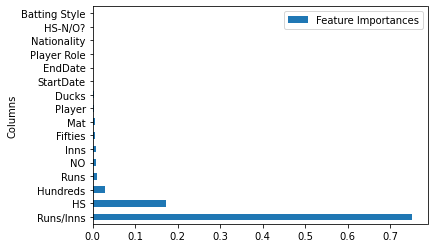

In [73]:
fi = pd.DataFrame({"Columns":X_train.columns,"Feature Importances":model.feature_importances_}).sort_values(by="Feature Importances", ascending=False)
fi.plot("Columns","Feature Importances","barh"), fi

In [85]:
# Look at Nationality
natMean = valid.groupby("Nationality", as_index=False).mean()[["Nationality","Ave","Predictions","Std. Dev"]]
natMean = natMean[~pd.isnull(natMean.Ave)]
print(natMean.Ave.std())
natMean

3.33


,Nationality,Ave,Predictions,Std. Dev
1,AUS,22.421875,20.212362,4.275242
2,BDESH,19.375000,20.902185,4.480359
3,ENG,20.031250,19.537153,4.061604
5,INDIA,24.562500,24.750173,4.712549
7,NZ,23.203125,23.047407,4.778867
8,PAK,25.828125,27.071804,6.609673
9,SA,25.281250,21.949866,6.484032
10,SL,18.281250,18.425867,2.983897
11,WI,16.406250,17.076922,5.150812


In [97]:
dfNew.groupby("Nationality", as_index=False)["Ave"].mean()

,Nationality,Ave
0,AFG,16.968750
1,AUS,24.531250
2,BDESH,17.031250
3,ENG,20.093750
4,ICC/INDIA,50.812500
5,INDIA,21.500000
6,IRE,17.984375
7,NZ,22.031250
8,PAK,20.546875
9,SA,21.781250


In [90]:
# As a whole (disregarding ICC/INDIA - only 2 players in this category), averages across the nations are in the same ballpark
# No need to one hot encode this category.
# Look at batting style
styleMean = valid.groupby("Batting Style", as_index=False).mean()[["Batting Style","Ave","Predictions","Std. Dev"]]
styleMean = styleMean[~pd.isnull(styleMean.Ave)]
print(styleMean.Ave.std())
styleMean

3.148


,Batting Style,Ave,Predictions,Std. Dev
0,L,24.562500,24.057192,5.770235
1,R,20.109375,20.073114,4.558621


In [96]:
dfNew.groupby("Batting Style", as_index=False)["Ave"].mean()

,Batting Style,Ave
0,L,24.00000
1,R,19.34375


In [93]:
# In neither the training nor validation sets do we have any significant change in the averages across batting styles.
# Since we have only 2 categories, I will one hot encode this category.
# Consider Playing Role
roleMean = valid.groupby("Player Role", as_index=False).mean()[["Player Role","Ave","Predictions","Std. Dev"]]
roleMean = roleMean[~pd.isnull(roleMean.Ave)]
print(roleMean.Ave.std())
roleMean

7.4


,Player Role,Ave,Predictions,Std. Dev
0,bowler,11.625000,11.016081,3.286706
1,nan,18.140625,21.668418,6.722305
3,bowling allrounder,26.437500,25.748531,7.035327
4,wicketkeeper batsman,30.125000,30.668913,7.385583
5,batting allrounder,32.843750,32.913294,4.198881
6,opening batsman,32.656250,34.044763,6.462567
7,batsman,25.703125,26.899956,5.775632
8,middle-order batsman,33.000000,31.105505,5.612753
9,top-order batsman,30.109375,31.126368,5.766931


In [95]:
dfNew.groupby("Player Role", as_index=False)["Ave"].mean()

,Player Role,Ave
0,bowler,11.695312
1,nan,17.218750
2,wicketkeeper,21.421875
3,bowling allrounder,24.921875
4,wicketkeeper batsman,28.031250
5,batting allrounder,31.890625
6,opening batsman,30.671875
7,batsman,31.609375
8,middle-order batsman,33.312500
9,top-order batsman,34.031250


In [ ]:
# One Hot Encoding could help distinguish bowlers, wicketkeepers and batsmen. Probably won't offer any help distinguishing smaller categories.
# Try One Hot Encoding on Player Role and Batting Style

In [ ]:
# Look at feature importances
fi = pd.DataFrame({"Columns":X_train.columns,"Feature Importances":model.feature_importances_}).sort_values(by="Feature Importances", ascending=False)
fi.plot("Columns","Feature Importances","barh"), fi

In [ ]:
colkeep = fi[fi["Feature Importances"]>0.01]
colkeep = colkeep["Columns"]
model = RandomForestRegressor(n_jobs=-1, oob_score=True)
model.fit(X_train[colkeep],y_train)
print("Training R^2:", model.score(X_train[colkeep],y_train))
print("Training RMSE:", np.sqrt(mean_squared_error(y_train,model.predict(X_train[colkeep]))))
print("OOB Score:", model.oob_score_)

In [ ]:
fi = pd.DataFrame({"Columns":X_train[colkeep].columns,"Feature Importances":model.feature_importances_}).sort_values(by="Feature Importances", ascending=False)
fi.plot("Columns","Feature Importances","barh"), fi

In [ ]:
# First look at the affect on OOB-Score after increasing n_estimators
# Then consider min_samples_split, min_samples_leaf, max_features, min_impurity_decrease
model = RandomForestRegressor(n_jobs=-1, oob_score=True, min_samples_split=5, n_estimators=100)
model.fit(X_train[colkeep],y_train)
print("Training R^2:", model.score(X_train[colkeep],y_train))
print("Training RMSE:", np.sqrt(mean_squared_error(y_train,model.predict(X_train[colkeep]))))
print("OOB Score:", model.oob_score_)

In [ ]:
trees = [5,10,20,30,40,50,60,70,80,90,100]
scores = []
for treenum in trees:
    model = RandomForestRegressor(n_jobs=-1,oob_score=True,n_estimators=treenum)
    model.fit(X_train[colkeep],y_train)
    scores.append(model.oob_score_)
    
plt.title("Graph of OOB_Score against number of estimators in the random forest")
plt.ylabel("OOB-Score")
plt.xlabel("Number of Trees")
plt.plot(trees,scores)
plt.show()

In [ ]:
# The graph appears to show that the more trees we use, the better the OOB-Score BUT the graph levels off. Choose 70 trees.
model = RandomForestRegressor(n_jobs=-1,oob_score=True,n_estimators=70)
model.fit(X_train[colkeep],y_train)
print("Training R^2:", model.score(X_train[colkeep],y_train))
print("Training RMSE:", np.sqrt(mean_squared_error(y_train,model.predict(X_train[colkeep]))))
print("OOB Score:", model.oob_score_)